In [1]:
import numpy as np
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei



def KWSA(F, w, m, c, d):
    """ 
    Kiefer-Wolfowitz stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample size (null in this case)
    - d: dimension
    - c: costant
    
    """

    F_wc = np.array([F(w + c * e(i, d)) for i in range(d)])
    return (F_wc - F(w)) / c




def IRDSA(F, w, m, c, d):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - d: features dimension
    - c: costant
    
    """
    z = np.random.normal(0, 1, (d, m))
    F_w = F(w)
    return np.mean([(F(w + c * z[:,i]) - F_w) / c * z[:,i] for i in range(m)], axis = 0)
    
    


def detZFW(F, L, d, w0, r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - L: Lip constant
    - d: dimension
    - w0: starting point
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """

    gamma = lambda t: 2/(t+2)
    c = lambda t: L*gamma(t)/d
    w = w0
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = KWSA(F, w, None, c(t), d)
        # compute the linear problem solution on the L1 Ball of radius r
        i_k = np.argmax(np.abs(gt))
        ei = e(i_k, d) * r
        v = np.sign(-gt[i_k]) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = F(w_pred) - F(w)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t

## Stochastic lasso regression

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [4]:
# space dimension
d = X.shape[1]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [5]:
#w_star = np.linalg.inv(X * X.T) * X * y

In [6]:
# define the objective function
F = lambda w: 0.5 * np.sum(np.power(y - X @ w, 2))

In [7]:
# initialize prarameters for the algorithm

# stating point 
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)
#print(w0)
#print(F(w0))

# Lipschitz constant computation
L = 3 #np.linalg.norm(X.dot(w0))
print(f"L: {L}")

L: 3


In [17]:
%%time
fpred, f, w_det, mean, t = detZFW(F, L, d, w0, T=100)

Loss evaluation at time 1:	343218.6203

Loss evaluation at time 2:	60852.1867

Loss evaluation at time 3:	21546.1982

Loss evaluation at time 4:	10174.2399

Loss evaluation at time 5:	5634.6010

Loss evaluation at time 6:	3455.4252

Loss evaluation at time 7:	2275.3260

Loss evaluation at time 8:	1579.2618

Loss evaluation at time 9:	1141.5884

Loss evaluation at time 10:	852.3419

Loss evaluation at time 11:	653.4024

Loss evaluation at time 12:	512.0179

Loss evaluation at time 13:	408.7466

Loss evaluation at time 14:	331.5386

Loss evaluation at time 15:	272.6494

Loss evaluation at time 16:	226.9440

Loss evaluation at time 17:	190.9247

Loss evaluation at time 18:	162.1523

Loss evaluation at time 19:	138.8899

Loss evaluation at time 20:	119.8777

Loss evaluation at time 21:	104.1867

Loss evaluation at time 22:	91.1216

Loss evaluation at time 23:	80.1548

Loss evaluation at time 24:	70.8810

Loss evaluation at time 25:	62.9855

Loss evaluation at time 26:	56.2213

Loss evaluat

In [18]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w_det}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 634571.9989119768

F(w_pred) = 179684.5113658399

F(w) = 179683.44223484417

w = [2.77132211e-06 4.02983567e-06 3.08795393e-08 3.61756009e-06
 2.69784349e-06 1.33729259e-06 3.56824604e-06 9.99808524e-01
 3.75108695e-06 2.87166285e-06 3.92599860e-06 8.70501166e-07
 1.45329881e-06 2.60587958e-06 2.46921740e-06 4.83692308e-06
 3.96307199e-06 5.32262194e-08 1.63464558e-06 1.77673727e-06
 4.14304857e-06 3.51816278e-06 4.02127965e-06 4.21880637e-07
 4.91732298e-06 4.98055814e-06 3.62418132e-06 8.70545149e-07
 2.30748277e-06 1.89517021e-06 4.86767458e-06 8.97616203e-07
 4.09760962e-06 2.50305167e-06 9.36964163e-07 1.58319234e-06
 3.75474925e-06 4.66322230e-07 2.68929516e-06 5.09959305e-07
 4.26252570e-06 4.95833253e-06 2.29084708e-06 1.23152751e-06
 1.08541133e-06 4.25249003e-06 3.62232723e-06 4.27706155e-06
 2.70622791e-06 2.62828100e-07 8.66572037e-07 1.18812470e-06
 2.15455175e-06 4.23199472e-06]

average w = [1.39951766e-04 2.03506701e-04 1.55941674e-06 1.82686785e-04
 1.

## Stochastic Gradient Free Frank Wolfe

In [8]:
def stochasticZFW(F, d,  w0, method = "IRDSA", r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - method: zeroth order oracle
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    Parameters_dict = {"KWSA": {"m": None, 
                                "c": lambda t: 2 / (np.sqrt(d) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / np.power(t+8, 2/3),
                                "oracle": KWSA},
                       
                   
                       "RDSA": {"m": 1, 
                                "c": lambda t: 2 / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(d, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA},
                   
                       "IRDSA": {"m": 6, 
                                "c": lambda t: 2 * np.sqrt(6) / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(1+d/6, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA}
                  
                        }
    
    return sZFW(F, d, w0, Parameters_dict[method], r, T, eps)
    
  

    
def sZFW(F, d, w0, params, r, T, eps):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - params: dict of parameters for the selected method
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    loss = []
    gamma = lambda t: 2/(t+8)
    w = w0
    dt = np.zeros(d)
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = params["oracle"](F, w, params["m"], params["c"](t), d)
        dt = (1 - params["p"](t)) * dt + params["p"](t) * gt
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(dt)), d) * r
        v = np.sign(-dt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss


In [21]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=1, T=1000, eps=1e-5)

Loss evaluation at time 1:	23520.7633

Loss evaluation at time 2:	68256.0980

Loss evaluation at time 3:	35400.1179

Loss evaluation at time 4:	5251.6896

Loss evaluation at time 5:	68175.9540

Loss evaluation at time 6:	32987.8042

Loss evaluation at time 7:	52528.1515

Loss evaluation at time 8:	15011.0693

Loss evaluation at time 9:	11947.4145

Loss evaluation at time 10:	31412.1975

Loss evaluation at time 11:	22820.9349

Loss evaluation at time 12:	2880.4525

Loss evaluation at time 13:	17452.3038

Loss evaluation at time 14:	14552.4723

Loss evaluation at time 15:	12262.5886

Loss evaluation at time 16:	10430.8393

Loss evaluation at time 17:	10735.7815

Loss evaluation at time 18:	9265.6786

Loss evaluation at time 19:	8053.8229

Loss evaluation at time 20:	7045.8984

Loss evaluation at time 21:	6200.7023

Loss evaluation at time 22:	5486.6113

Loss evaluation at time 23:	4879.0894

Loss evaluation at time 24:	4358.9075

Loss evaluation at time 25:	3910.8544

Loss evaluation at 

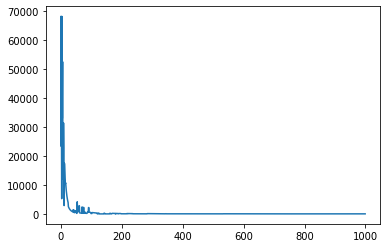

In [22]:
plt.plot(loss)

In [23]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 183506.7064278634

F(w) = 183528.72376379377

w = [ 4.10911465e-04  1.57315358e-06  1.20546499e-08  1.41221084e-06
  1.05317500e-06  5.22047748e-07  2.67517668e-01  7.31129174e-01
  6.87140792e-04  2.27947111e-05  1.43396712e-04  3.39823294e-07
  5.67333862e-07  1.01727444e-06  9.63924717e-07  1.88822163e-06
  1.54709061e-06  2.07782710e-08  6.38127397e-07  6.93596671e-07
  1.61734925e-06  1.37340846e-06  1.56981352e-06  1.64692333e-07
  1.91960787e-06  1.94429340e-06  1.41479562e-06  3.39840463e-07
  9.00787298e-07  7.39830121e-07  1.90022630e-06  3.50408370e-07
  1.59961095e-06  9.77132823e-07  3.65768893e-07  6.18041258e-07
  1.46576628e-06  1.82041291e-07  1.04983792e-06  1.99076184e-07
  1.66399033e-06  1.93561704e-06  8.94293116e-07  4.80759533e-07
  4.23719196e-07  1.66007264e-06  1.41407182e-06  1.66966478e-06
  2.66707984e-05 -1.56600752e-05  3.38289454e-07  4.63816092e-07
  8.41086607e-07  1.65207175e-06]

average w = [ 5.72348063e-03  1.98020707e-04  1.5

## Zeroth order stochastic accelerated gradient method with inexact updates

In [21]:
def InexactUpdate(g, d, v, r, gamma, mu):
    """
    INPUT
    - g: gradient approximation 
    - d: dimension
    - v: starting point
    - r: radius
    - gamma: decreasing coefficient
    - mu: threshold
    """
    
    haty = v
    t = 1
    while True:
        # ARGMIN PROBLEM
        ht1 = g + gamma*(haty - v)
        i_k = np.argmax(np.abs(ht1))
        ei = e(i_k, d) * r
        yt = np.sign(-ht1[i_k]) * ei
        if np.dot(ht1, yt - haty) >= - mu:
            break
        else:
            haty = (t-1)/(t+1) * haty + 2/(t+1)*yt
            t +=1
    return haty
    

L = 3
D = 2*r*10 # we will start from m = 6, up to T * (T+1) / D * (d+3)
B = 1


def IZFW(F, d, w0, L, B, D, r = 1, T = 100, eps = 1e-6):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - L: lipschitz
    - B: 1
    - D: number greater than diamater l1 ball
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    alpha = lambda t: 2/(t+2)
    gamma = lambda t: 4*L/t
    mu = lambda t: L*D/(t*T)
    m = lambda t: t * (t+1) / D * (d+3)#np.max([(d+5)*B*T, d+3])
    c = 1 / (np.sqrt(2*T)) * np.max([1/(d+3), np.sqrt(D/(d*(T+1)))]) # smoothing parameter now fixed
    
    loss = []
    v, w = w0, w0
    partial = 0
    
    for t in range(1, T+1):
        dt = (1-alpha(t)) * w + alpha(t) * v
        g = IRDSA(F, dt, int(np.ceil(m(t))), c, d)
        v = InexactUpdate(g, d, v, r, gamma(t), mu(t)) #ICG
        w_pred = w
        w = (1 - alpha(t)) * w + alpha(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        print(int(np.ceil(m(t))))
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss

I parametri degli algoritmi (L per deterministic FW e IGC + tutti quelli di IGC che sono collegati al gradiente, tipo varianza del grad e grad stesso)

I grafici uguali o no? Che differenza c'è tra # oracolo e # di iterazioni? (Loss disponibile solo a fine chiamate oracolo)

I dataset: il primo ok, secondo stesso preprocessing ma abbiamo risultati diversi, il terzo non sappiamo cos'è e come si usa.



In [22]:
%%time
fpred, f, w, mean, t, loss = IZFW(F, d, w0, L, B, r = 1, T = 100, eps = 1e-3)

Loss evaluation at time 1:	343218.6203

57
Loss evaluation at time 2:	60852.1867

171
Loss evaluation at time 3:	21546.1982

342
Loss evaluation at time 4:	10174.2399

570
Loss evaluation at time 5:	5634.6010

855
Loss evaluation at time 6:	199.7743

1197
Loss evaluation at time 7:	3182.5927

1596
Loss evaluation at time 8:	967.1668

2052
Loss evaluation at time 9:	2234.7473

2565
Loss evaluation at time 10:	1091.7662

3135
Loss evaluation at time 11:	935.3902

3762
Loss evaluation at time 12:	1803.3786

4446


KeyboardInterrupt: 

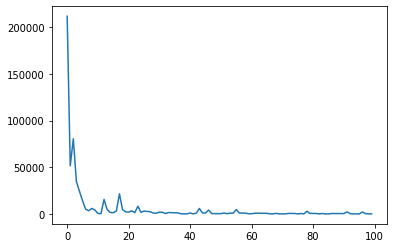

In [23]:
plt.plot(loss)

In [24]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')# m=6, T=1000

OUTPUT:

F(w_pred) = 197914.107239128

F(w) = 197869.3747248715

w = [2.34933557e-02 4.02983567e-06 3.08795393e-08 3.61756009e-06
 3.69130200e-03 1.33729259e-06 4.01673147e-01 5.04176608e-01
 4.69849198e-02 2.87166285e-06 1.98059062e-02 8.70501166e-07
 1.45329881e-06 2.60587958e-06 2.46921740e-06 4.83692308e-06
 3.96307199e-06 5.32262194e-08 1.63464558e-06 1.77673727e-06
 4.14304857e-06 3.51816278e-06 4.02127965e-06 4.21880637e-07
 4.91732298e-06 4.98055814e-06 3.62418132e-06 8.70545149e-07
 2.30748277e-06 1.89517021e-06 4.86767458e-06 8.97616203e-07
 4.09760962e-06 2.50305167e-06 9.36964163e-07 1.58319234e-06
 3.75474925e-06 4.66322230e-07 2.68929516e-06 5.09959305e-07
 4.26252570e-06 4.95833253e-06 2.29084708e-06 1.23152751e-06
 1.08541133e-06 4.25249003e-06 3.62232723e-06 4.27706155e-06
 2.70622791e-06 2.62828100e-07 8.66572037e-07 1.18812470e-06
 2.15455175e-06 4.23199472e-06]

average w = [5.64144616e-02 2.03506701e-04 1.55941674e-06 1.82686785e-04
 1.64107509e-02 6.75332759e-05 4

In [61]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')#100

OUTPUT:

F(w_pred) = 198152.00822366346

F(w) = 198018.65622128965

w = [4.47739238e-02 1.14471662e-03 4.80743181e-09 5.63194071e-07
 4.20009460e-07 2.08194264e-07 3.76933956e-01 5.25665416e-01
 2.27723602e-02 4.47070249e-07 2.64906774e-02 1.35522585e-07
 2.20039787e-03 4.05692205e-07 3.84416172e-07 7.53028653e-07
 6.16984540e-07 8.28643904e-09 2.54487188e-07 2.76608507e-07
 6.45003906e-07 5.47719559e-07 6.26046507e-07 6.56798139e-08
 7.65545583e-07 7.75390248e-07 5.64224887e-07 1.35529433e-07
 3.59236773e-07 2.95046551e-07 7.57816151e-07 1.39743946e-07
 6.37929816e-07 3.89683605e-07 1.45869771e-07 2.46476774e-07
 5.84552147e-07 7.25986323e-08 4.18678626e-07 7.93922008e-08
 6.63604513e-07 7.71930090e-07 3.56646873e-07 1.91728395e-07
 1.68980532e-07 6.62042126e-07 5.63936236e-07 6.65867503e-07
 4.21314775e-07 4.09179734e-08 1.34910885e-07 1.84971298e-07
 3.35427952e-07 6.58851346e-07]

average w = [2.18088624e-02 5.61318427e-03 7.23518488e-07 8.47607077e-05
 6.32114238e-05 3.13332367e-0